# Preprocessing and Feature Analysis

In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from tensorflow.keras import layers

In [2]:
file_path = "/Users/kiyoshitakeuchi/Desktop/Machine Learning/titanic/"
file_name = "train.csv"
test_file_name = "test.csv"

In [3]:
train_set = pd.read_csv(file_path + file_name)
train_set.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Change the label depending on the model.

In [4]:
label = "Survived"
test_set = pd.read_csv(file_path + test_file_name)
test_set.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


Some of the inputs that are numeric are categorical. I try to automate the finding of the categorical features this way. The list should not be too unmanageable, and from there one can remove the non-categorical elements.

In [6]:
categorical = []

for name, column in test_set.items():
        dtype = column.dtype
        if dtype == "int64" and len(np.unique(train_set[name])) < 20:
            categorical.append(name)
print(categorical)

ncf_dict = {name:"str" for name in categorical}
test_set = test_set.astype(ncf_dict)

['Pclass', 'SibSp', 'Parch']


In [8]:
items_to_remove = ['SibSp']

for element in items_to_remove:
    categorical.remove(element)
    
print(categorical)

['Pclass', 'Parch']


We can remove the rows that have NaNs if there are many examples. If the input is categorical, we should replace a NaN with a ? instead of the mean/median.

In [9]:
def remove_nan(data_frame): 
    temporary_frame = data_frame.copy().drop(categorical, axis=1)
    mean = temporary_frame.select_dtypes(include = 'number').mean()
    mean = mean.to_dict()
    data_frame.fillna(value=mean, inplace=True)
    data_frame.fillna(value="?", inplace=True)
    return

remove_nan(test_set)
remove_nan(train_set)

In [10]:
train_set.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,?,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,?,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,?,S


In [11]:
features = train_set.copy().astype(ncf_dict)
labels = features.pop(label)

In [12]:
features_dict = {name: np.array(value) 
                         for name, value in features.items()}

In [13]:
def preprocess_data(data_frame):    
    inputs = {}

    for name, column in data_frame.items():
        dtype = column.dtype
        if dtype == object:
            dtype = tf.string
        else:
            dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
        
    numeric_inputs = {name:input for name, input in inputs.items() 
                      if input.dtype==tf.float32}


    x = layers.Concatenate()(list(numeric_inputs.values()))
    norm = layers.Normalization()
    norm.adapt(np.array(train_set[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]
    
    for name, input in inputs.items():
        if input.dtype == tf.float32 and name not in categorical:
            continue 
            
        if name in categorical:
            data_frame[name] = data_frame[name].astype(str)
        
        lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(data_frame[name]))
        
            
        one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
        x = lookup(input)
        x = one_hot(x)
        preprocessed_inputs.append(x)
    
    preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

    preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
    
    return [inputs, preprocessing]

# Model

In [14]:
from matplotlib import pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [15]:
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

We have to choose the type of model we want, classification/regression.

In [46]:
model_type = "Classification"

if model_type == "Classification":
    model_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model_monitor = "val_binary_crossentropy"
    model_activation = "sigmoid"
    model_metric = "binary_crossentropy"
elif model_type == "Regression":
    model_loss = tf.keras.losses.MeanAbsoluteError()
    model_monitor = "val_mean_absolute_error"
    model_activation = "ReLU"
    model_metric = "mean_absolute_error"

In [32]:
N_VALIDATION = int(1e3)
N_TRAIN = len(train_set)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [33]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

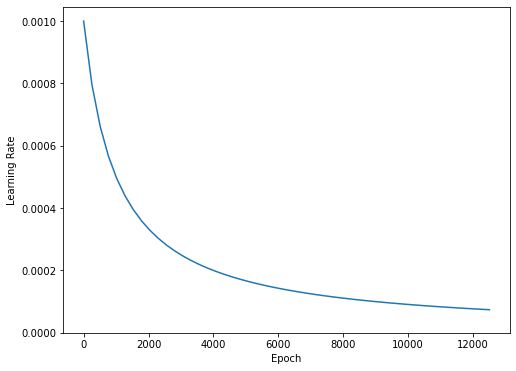

In [34]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [35]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor=model_monitor, patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [148]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=model_loss,
                metrics=[
                  model_loss,
                  'accuracy'])

    model.summary()

    history = model.fit(
        x=features_dict, 
        y=labels, 
        validation_split = 0.1,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [158]:
def working_model(data_frame):
    body = tf.keras.Sequential([
    layers.Dense(2 ** 6, kernel_regularizer=regularizers.l1(0.0001), activation=model_activation),
    layers.Dropout(0.5),
    layers.Dense(2 ** 6, kernel_regularizer=regularizers.l1(0.0001), activation=model_activation),
    layers.Dropout(0.5),
    layers.Dense(2 ** 6, kernel_regularizer=regularizers.l1(0.0001), activation=model_activation),
    layers.Dropout(0.5),
    layers.Dense(2 ** 6, kernel_regularizer=regularizers.l1(0.0001), activation=model_activation),
    layers.Dropout(0.5),
    layers.Dense(1)
    ])
    
    inputs, preprocessing_head = preprocess_data(data_frame)
    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)
    return model

In [177]:
def working_model_2(data_frame):
    body = tf.keras.Sequential([
    layers.Dense(2 ** 5, kernel_regularizer=regularizers.l2(0.0005), activation=model_activation),
    layers.Dropout(0.5),
    layers.Dense(1)
    ])
    
    inputs, preprocessing_head = preprocess_data(data_frame)
    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)
    return model

In [162]:
size_histories = {}

In [163]:
model_1 = working_model(features)
size_histories['Model_1'] = compile_and_fit(model_1, 'sizes/model_1')

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Cabin (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Embarked (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Fare (InputLayer)              [(None, 1)]          0           []                               
                                                                                           

In [178]:
model_2 = working_model_2(features)
size_histories['Model_2'] = compile_and_fit(model_2, 'sizes/model_2')

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Cabin (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Embarked (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Fare (InputLayer)              [(None, 1)]          0           []                               
                                                                                           

(0.0, 1.0)

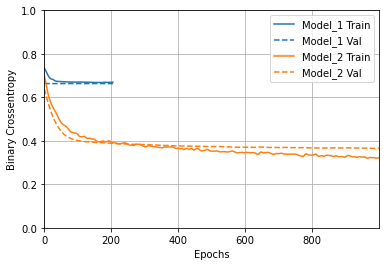

In [179]:
plotter = tfdocs.plots.HistoryPlotter(metric = model_metric, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.0, 1])

In [180]:
test_features_dict = {name: np.array(value) 
                         for name, value in test_set.copy().items()}
array = model_2.predict(test_features_dict)
array = np.array([item[0] for item in array])

Threshold

In [181]:
array = np.where(array > 0, 1, 0)

In [183]:
import csv

with open('titanic_solution_4.csv', 'w', newline='') as file:
    fieldnames = ['PassengerId', label]
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    n = 892
    for element in array:
        writer.writerow({'PassengerId': n, label: element})
        n += 1